In [1]:
import numpy as np
import nengo
from nengo.utils.ensemble import tuning_curves
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# Code from the previous example
def simulate_ens(mkens, T=1.0, Δt=1e-3, stim=lambda t: np.sin(2.0 * np.pi * t), seed=4912):
    np.random.seed(seed)
    with nengo.Network() as model:
        # Create our stimulus
        stim = nengo.Node(stim)

        # Create an ensemble with two neurons
        ens = mkens()

        # Feed the stimulus into the ensemble
        nengo.Connection(stim, ens)

        # Record the stimulus and the neural esponse
        p_stim = nengo.Probe(stim, synapse=None)
        p_spikes = nengo.Probe(ens.neurons, synapse=None)

    with nengo.Simulator(model, dt=Δt, progress_bar=None) as sim:
        # Fetch the tuning curves (this is just for visualising
        # the ensemble)   
        tuning_xs, tuning_A = tuning_curves(ens, sim)

        # Run the simulation for a while
        sim.run(1.0)

        # Fetch the discrete time steps and the neurons
        ts = sim.trange()
        xs = sim.data[p_stim]
        A = sim.data[p_spikes]

    # Compute the decoders
    D = np.linalg.lstsq(A, xs, rcond=None)[0]

    return tuning_xs, tuning_A, ts, xs, A, D

def simulate_two_neurons(*args, **kwargs):
    return simulate_ens(lambda: nengo.Ensemble(
        n_neurons=2, dimensions=1,
        encoders = [[1],[-1]],
        intercepts = [-.5, -.5],
        max_rates= [50, 50]), *args, **kwargs)

def simulate_n_neurons(n, *args, **kwargs):
    return simulate_ens(lambda: nengo.Ensemble(
        n_neurons=n, dimensions=1,
        max_rates=nengo.dists.Uniform(50, 100)), *args, **kwargs)

def rasterplot(ax, ts, A, full_vertical=False):
    N, n = A.shape
    color = matplotlib.cm.get_cmap('tab10')(0)
    for i in range(n):
        for t in ts[np.where(A[:, i] != 0)]:
            ax.plot([t, t], [i + 0.5, i + 1.5], color=color, zorder=4)
            if full_vertical:
                ax.plot([t, t], [0, n + 0.5], color='k', linestyle='--', linewidth=1.0, alpha=0.5, zorder=3)
    ax.set_ylim(0.5, n + 0.5)
    if n < 5:
        ax.set_yticks(list(range(1, n + 1)))
    else:
        ax.set_yticks(list(range(1, n + 1, int(np.ceil(n / 5)))))

In [3]:
def gaussian_filter(ts, sigma=14e-3, dt=1e-3):
    h = np.exp(-np.square(ts)/(2*np.square(sigma)))
    h = h / np.sum(h)
    return h

In [4]:
def plot_filtered(ts, xs, A, h, D, scale=25, figsize=(8, 3.5), show_legend=True):
    N, n = A.shape

    # Filter the spike trains with h
    A_flt = scale * np.apply_along_axis(
        lambda A: np.convolve(A, h, 'same'), axis=0, arr=A)

    # Plot the raster plot and the optimal value
    fig, ((ax1, ax3), (ax2, ax4)) = plt.subplots(2, 2, figsize=figsize)
    rasterplot(ax1, ts, A)
    ax1.set_xlabel('Time $t$')
    ax1.set_ylabel('Neuron index')
    twax = ax1.twinx()
    twax.set_ylabel('Filtered Input $x(t)$')
    twax.set_yticks([-1, 0, 1])
    twax.plot(ts, xs, 'k--')
    ax1.set_title('Spike trains')

    # Plot the decoded spike train
    ax2.plot(ts, (D.T @ A.T)[0], label="Decoded $\\hat x(t)$")
    ax2.plot(ts, xs, 'k--', label="Ideal $x(t)$")
    if show_legend:
        ax2.legend()
    ax2.set_xlabel('Time $t$')
    ax2.set_ylabel('Decoded value $\\hat x(t)$')
    ax2.set_title('Decoded output')
    fig.tight_layout(pad=0.5)

    # Plot the individual filtered spike trains
    for i in range(n):
        ax3.plot(ts, A_flt[:, i] * D[i])
    ax3.plot(ts, xs, 'k--', label="Ideal $x(t)$")
    ax3.set_xlabel('Time $t$')
    ax3.set_ylabel('Decoded value $\\hat x(t)$')
    ax3.set_title('Filtered outputs')
    fig.tight_layout(pad=0.5)

    # Plot the filtered decoded output
    ax4.plot(ts, (D.T @ A_flt.T)[0])
    ax4.plot(ts, xs, 'k--', label="Ideal $x(t)$")
    ax4.set_xlabel('Time $t$')
    ax4.set_ylabel('Decoded value $\\hat x(t)$')
    ax4.set_title('Filtered output sum')
    fig.tight_layout(pad=0.5)

    return fig

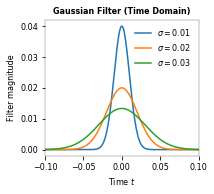

In [5]:
# Plot the Gaussian filter
dt = 1e-3
ts = np.arange(-1, 1, dt)
fig, ax = plt.subplots(figsize=(2.75, 2.5))
for sigma in [10e-3, 20e-3, 30e-3]:
    ax.plot(ts, gaussian_filter(ts, sigma=sigma), label="$\\sigma = {:.2f}$".format(sigma))
    ax.set_xlim(-0.1, 0.1)
    ax.set_xlabel("Time $t$")
    ax.set_ylabel("Filter magnitude")
ax.legend()
ax.set_title("Gaussian Filter (Time Domain)")

fig.savefig("../gaussian_filters.pdf", transparent=True, bbox_inches='tight')

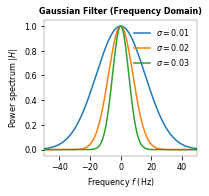

In [6]:
# Plot the Gaussian filter in the Frequency Domain
dt = 1e-3
ts = np.arange(-1, 1, dt)
fig, ax = plt.subplots(figsize=(2.75, 2.5))
for sigma in [10e-3, 20e-3, 30e-3]:
    h = gaussian_filter(ts, sigma=sigma)
    H = np.fft.fftshift(np.fft.fft(h))
    fs = np.fft.fftshift(np.fft.fftfreq(ts.size, dt))
    ax.plot(fs, np.abs(H), label="$\\sigma = {:.2f}$".format(sigma))
    ax.set_xlim(-50, 50)
    ax.set_xlabel("Frequency $f$ (Hz)")
    ax.set_ylabel("Power spectrum $|H|$")
ax.legend()
ax.set_title("Gaussian Filter (Frequency Domain)")

fig.savefig("../gaussian_filters_freq.pdf", transparent=True, bbox_inches='tight')

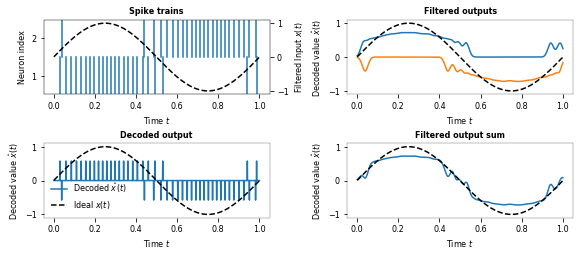

In [7]:
# Compute the spike trains for the two-neuron example and filter them with h
_, _, ts, xs, A, D = simulate_two_neurons()
ts_flt = ts - np.max(ts) / 2 # Centre the filter
fig = plot_filtered(ts, xs, A, gaussian_filter(ts_flt), D)
fig.savefig("../two_neurons_filtered.pdf", transparent=True, bbox_inches='tight')

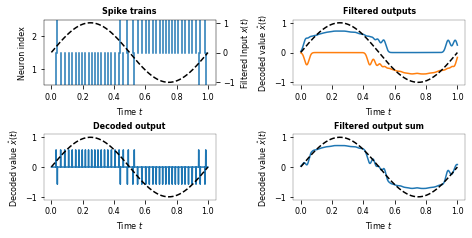

In [8]:
fig = plot_filtered(ts, xs, A, gaussian_filter(ts_flt), D, figsize=(6.5, 3.25), show_legend=False) # For the lecture notes
fig.savefig("../two_neurons_filtered_small.pdf", transparent=True, bbox_inches='tight')

In [9]:
def plot_analyse_signal(ts, xs, label="Signal", symbol="x"):
    dt = (ts[-1] - ts[0]) / (len(ts) - 1) # Trick for reconstructing dt
    
    Xs = np.fft.fftshift(np.fft.fft(xs))
    fs = np.fft.fftshift(np.fft.fftfreq(len(ts), dt))
    
    # Magic for auto-decting the bandwidth for the magnified plot
    bw = fs[np.max(np.where(np.abs(Xs) > 1e-3))]

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(6.5, 2.25))
    ax1.plot(ts, xs)
    ax1.set_xlabel('Time $t$ (s)')
    ax1.set_ylabel('{} ${}$'.format(label, symbol))
    ax1.set_title('Time domain')
    
    ax2.plot(fs, np.abs(Xs))
    ax2.set_xlabel('Frequency $f$ (Hz)')
    ax2.set_ylabel('Power spectrum $|{}|$'.format(symbol.upper()))
    ax2.set_title('Frequency domain')

    ax3.plot(fs, np.abs(Xs))
    ax3.set_xlabel('Frequency $f$ (Hz)')
    ax3.set_ylabel('Power spectrum $|{}|$'.format(symbol.upper()))
    ax3.set_xlim(-min(20, 2 * bw), min(20, 2 * bw))
    ax3.set_title('Frequency domain (magnified)')

    fig.tight_layout(pad=0.5)
    return fig

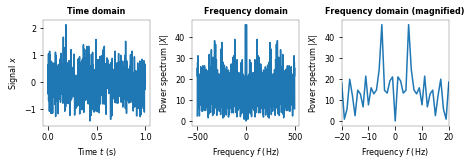

In [10]:
# Generate a random signal
T, dt = 1.0, 1e-3
ts = np.arange(0, T, dt)
signal = np.random.normal(0, 0.5, len(ts))
signal -= np.mean(signal) # Remove DC offset

# Plot the signal
fig = plot_analyse_signal(ts, signal)
fig.savefig("../white_noise.pdf", transparent=True, bbox_inches='tight')

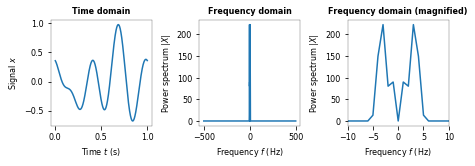

In [11]:
# Generate a white noise signal using Nengo
period, dt = 1.0, 1e-3
process = nengo.processes.WhiteSignal(period, high=5.0, rms=0.5)
signal, ts = process.run(period)[:, 0], process.trange(period)

# Plot the signal
fig = plot_analyse_signal(ts, signal)
fig.savefig("../white_noise_5hz.pdf", transparent=True, bbox_inches='tight')

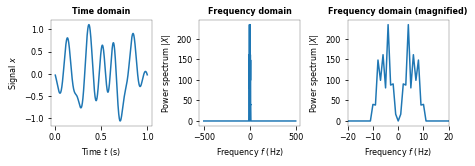

In [12]:
period, dt = 1.0, 1e-3
process = nengo.processes.WhiteSignal(period, high=10.0, rms=0.5)
signal, ts = process.run(period)[:, 0], process.trange(period)
fig = plot_analyse_signal(ts, signal)
fig.savefig("../white_noise_10hz.pdf", transparent=True, bbox_inches='tight')

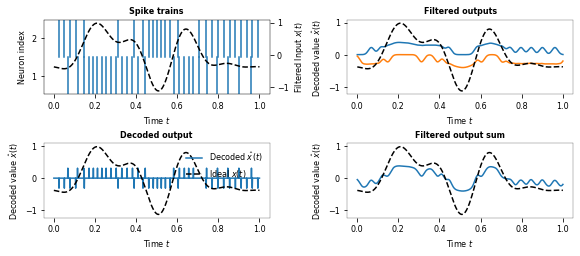

In [13]:
# Compute the spike trains for the two-neuron example and filter them with h
_, _, ts, xs, A, D = simulate_two_neurons(stim=nengo.processes.WhiteSignal(period, high=5.0, rms=0.5))
ts_flt = ts - np.max(ts) / 2 # Centre the filter
fig = plot_filtered(ts, xs, A, gaussian_filter(ts_flt), D)
fig.savefig("../two_neurons_filtered_white_noise.pdf", transparent=True, bbox_inches='tight')

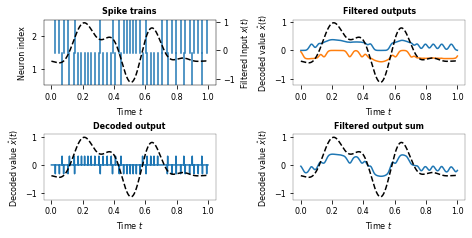

In [14]:
fig = plot_filtered(ts, xs, A, gaussian_filter(ts_flt), D, figsize=(6.5, 3.25), show_legend=False) # For the lecture notes
fig.savefig("../two_neurons_filtered_white_noise_small.pdf", transparent=True, bbox_inches='tight')

In [15]:
def compute_optimal_filter(
        # Signal generated from your white noise generator
        x,
        # Spike train from the previous part
        spikes,
        # Time step size
        dt=1e-3,
        simple=False
    ):

    X = np.fft.fftshift(np.fft.fft(x))

    # x and X should (effectively) be 1D-arrays
    assert x.ndim == 1 and X.ndim == 1
    assert x.shape[0] == X.shape[0]

    Nt = x.size

    # Make sure that "spikes" is a 2 x Nt array
    assert spikes.ndim == 2
    assert spikes.shape[0] == 2              
    assert spikes.shape[1] == Nt

    T = Nt * dt
    ts = np.arange(Nt) * dt - T / 2.0
    fs = np.arange(Nt) / T - Nt / (2.0 * T)
    omega = fs * 2.0 * np.pi
    r = spikes[0] - spikes[1]
    R = np.fft.fftshift(np.fft.fft(r))

    sigma_t = 25e-3

    if simple:
        H = (X * R.conjugate()) / (R * R.conjugate()) # np.abs(R)^2
    else:
        W2 = np.exp(-omega**2*sigma_t**2)
        W2 = W2 / sum(W2)
        CP = X*R.conjugate()
        WCP = np.convolve(CP, W2, 'same')
        RP = R*R.conjugate()
        WRP = np.convolve(RP, W2, 'same')
        XP = X*X.conjugate()
        WXP = np.convolve(XP, W2, 'same')
        H = WCP / WRP
    h = np.fft.fftshift(np.fft.ifft(np.fft.ifftshift(H))).real
    XHAT = H*R
    xhat = np.fft.ifft(np.fft.ifftshift(XHAT)).real

    return ts, fs, R, H, h, XHAT, xhat

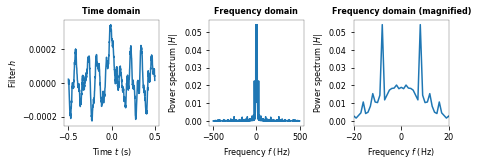

In [16]:
# Compute the filter on a long response
_, _, _, xs_flt, A_flt, _ = simulate_two_neurons(T=10.0, stim=nengo.processes.WhiteSignal(10.0, high=5.0, rms=0.5))
_, _, _, H, h, _, _ = compute_optimal_filter(xs_flt[:, 0], A_flt.T, simple=True)

fig = plot_analyse_signal(ts - np.max(ts) / 2, h, label="Filter", symbol="h")
fig.savefig("../optimal_filter.pdf", transparent=True, bbox_inches='tight')

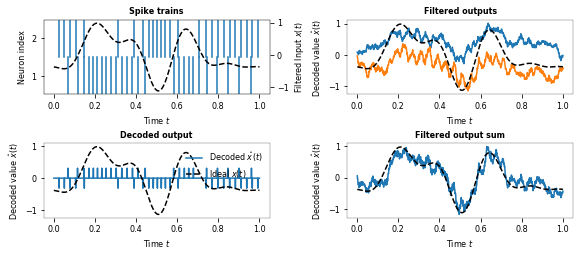

In [17]:
# Compute the spike trains for the two-neuron example and filter them with h
_, _, ts, xs, A, D = simulate_two_neurons(stim=nengo.processes.WhiteSignal(period, high=5.0, rms=0.5))
ts_flt = ts - np.max(ts) / 2 # Centre the filter
fig = plot_filtered(ts, xs, A, h, D, scale=2650)
fig.savefig("../two_neurons_filtered_optimal_simple.pdf", transparent=True, bbox_inches='tight')

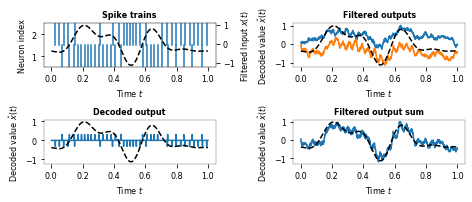

In [18]:
fig = plot_filtered(ts, xs, A, h, D, scale=2650, figsize=(6.5, 2.75), show_legend=False) # For the lecture notes
fig.savefig("../two_neurons_filtered_optimal_simple_small.pdf", transparent=True, bbox_inches='tight')

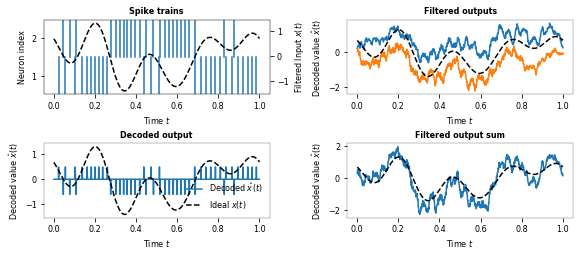

In [19]:
# Compute the spike trains for the two-neuron example and filter them with h
_, _, ts, xs, A, D = simulate_two_neurons(stim=nengo.processes.WhiteSignal(period, high=5.0, rms=0.5), seed=9812)
ts_flt = ts - np.max(ts) / 2 # Centre the filter
fig = plot_filtered(ts, xs, A, h, D, scale=2650)
fig.savefig("../two_neurons_filtered_optimal_simple_2.pdf", transparent=True, bbox_inches='tight')

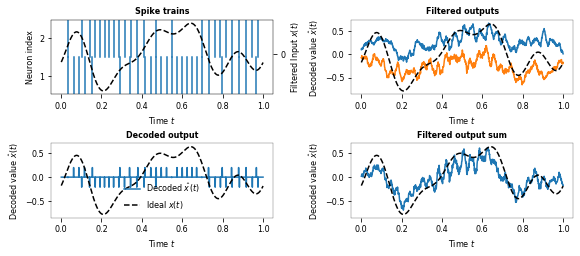

In [20]:
# Compute the spike trains for the two-neuron example and filter them with h
_, _, ts, xs, A, D = simulate_two_neurons(stim=nengo.processes.WhiteSignal(period, high=5.0, rms=0.5), seed=458)
ts_flt = ts - np.max(ts) / 2 # Centre the filter
fig = plot_filtered(ts, xs, A, h, D, scale=2650)
fig.savefig("../two_neurons_filtered_optimal_simple_3.pdf", transparent=True, bbox_inches='tight')

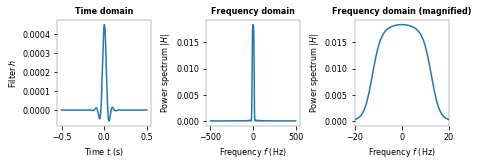

In [21]:
# Compute the filter on a long response
_, _, _, xs_flt, A_flt, _ = simulate_two_neurons(T=10.0, stim=nengo.processes.WhiteSignal(10.0, high=5.0, rms=0.5))
_, _, _, H, h, _, _ = compute_optimal_filter(xs_flt[:, 0], A_flt.T)

fig = plot_analyse_signal(ts - np.max(ts) / 2, h, label="Filter", symbol="h")
fig.savefig("../optimal_filter_improved.pdf", transparent=True, bbox_inches='tight')

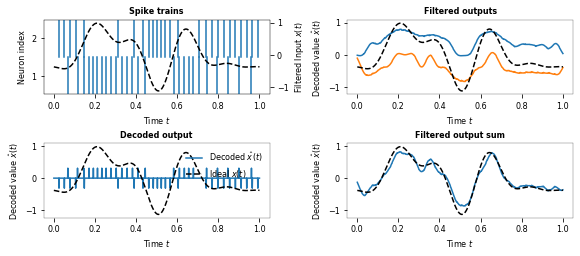

In [22]:
# Compute the spike trains for the two-neuron example and filter them with h
_, _, ts, xs, A, D = simulate_two_neurons(stim=nengo.processes.WhiteSignal(period, high=5.0, rms=0.5))
ts_flt = ts - np.max(ts) / 2 # Centre the filter
fig = plot_filtered(ts, xs, A, h * 110, D)
fig.savefig("../two_neurons_filtered_optimal.pdf", transparent=True, bbox_inches='tight')

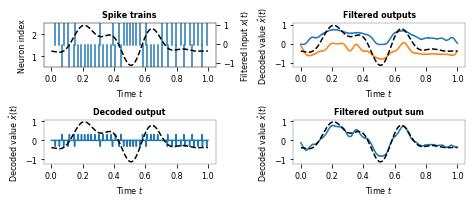

In [23]:
fig = plot_filtered(ts, xs, A, h, D, scale=2650, figsize=(6.5, 2.75), show_legend=False) # For the lecture notes
fig.savefig("../two_neurons_filtered_optimal_small.pdf", transparent=True, bbox_inches='tight')

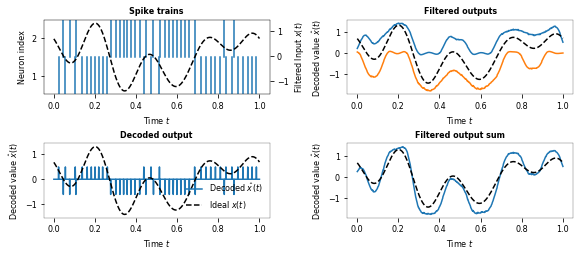

In [24]:
# Compute the spike trains for the two-neuron example and filter them with h
_, _, ts, xs, A, D = simulate_two_neurons(stim=nengo.processes.WhiteSignal(period, high=5.0, rms=0.5), seed=9812)
ts_flt = ts - np.max(ts) / 2 # Centre the filter
fig = plot_filtered(ts, xs, A, h * 110, D)
fig.savefig("../two_neurons_filtered_optimal_2.pdf", transparent=True, bbox_inches='tight')

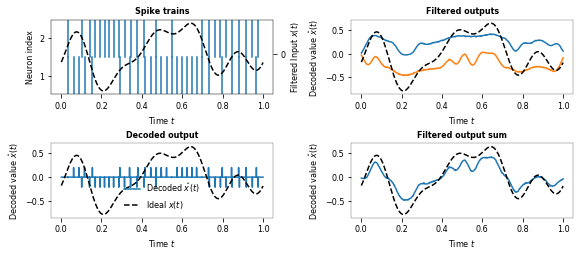

In [25]:
# Compute the spike trains for the two-neuron example and filter them with h
_, _, ts, xs, A, D = simulate_two_neurons(stim=nengo.processes.WhiteSignal(period, high=5.0, rms=0.5), seed=458)
ts_flt = ts - np.max(ts) / 2 # Centre the filter
fig = plot_filtered(ts, xs, A, h, D, scale=2560)
fig.savefig("../two_neurons_filtered_optimal_3.pdf", transparent=True, bbox_inches='tight')

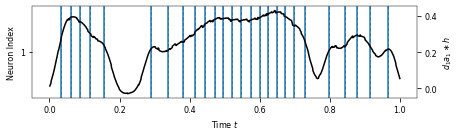

In [26]:
# Compute the spike trains for the two-neuron example and filter them with h
_, _, ts, xs, A, D = simulate_two_neurons(stim=nengo.processes.WhiteSignal(period, high=5.0, rms=0.5), seed=458)
ts_flt = ts - np.max(ts) / 2 # Centre the filter

fig, ax = plt.subplots(1, 1, figsize=(6.5, 2))
rasterplot(ax, ts, A[:, 0:1], full_vertical=True)
tw = ax.twinx()
#tw.plot(ts, xs, 'k--')
tw.plot(ts, np.convolve((A[:, 0:1])[:, 0] * D[0] * 2650, h, 'same'), 'k-')
ax.set_xlabel('Time $t$')
ax.set_ylabel('Neuron Index')
tw.set_ylabel('$d_1 a_1 \\ast h$')

fig.tight_layout()
fig.savefig("../filter_magnification.pdf", transparent=True, bbox_inches='tight')

In [27]:
def synaptic_filter(ts, tau, n):
    h = (ts > 0) * np.power(ts, n) * np.exp(-ts / tau)
    h /= np.sum(h)
    return h

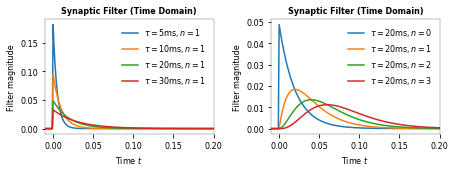

In [28]:
# Plot the synaptic filter for different k and tau
dt = 1e-3
ts = np.arange(-1, 1, dt)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6.5, 2.5))
for tau in [5e-3, 10e-3, 20e-3, 30e-3]:
    ax1.plot(ts, synaptic_filter(ts, tau=tau, n=0), label="$\\tau = {}\\mathrm{{ms}}, n=1$".format(int(tau*1e3)))
    ax1.set_xlabel("Time $t$")
    ax1.set_ylabel("Filter magnitude")

for n in [0, 1, 2, 3]:
    ax2.plot(ts, synaptic_filter(ts, tau=20e-3, n=n), label="$\\tau = 20\\mathrm{{ms}}, n={}$".format(n))
    ax2.set_xlabel("Time $t$")
    ax2.set_ylabel("Filter magnitude")
    
ax1.set_xlim(-0.01, 0.2)
ax1.legend()
ax1.set_title("Synaptic Filter (Time Domain)")

ax2.set_xlim(-0.01, 0.2)
ax2.legend()
ax2.set_title("Synaptic Filter (Time Domain)")

fig.tight_layout()
fig.savefig("../synaptic_filters.pdf", transparent=True, bbox_inches='tight')

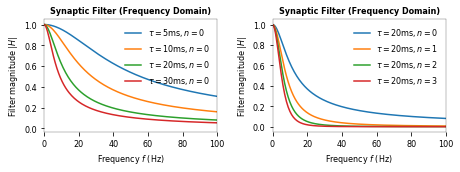

In [29]:
# Plot the synaptic filter for different k and tau
dt = 1e-3
ts = np.arange(-1, 1, dt)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6.5, 2.5))
for tau in [5e-3, 10e-3, 20e-3, 30e-3]:
    h = synaptic_filter(ts, tau=tau, n=0)
    H = np.fft.fftshift(np.fft.fft(h))
    fs = np.fft.fftshift(np.fft.fftfreq(ts.size, dt))

    ax1.plot(fs, np.abs(H), label="$\\tau = {}\\mathrm{{ms}}, n=0$".format(int(tau*1e3)))
    ax1.set_xlabel("Frequency $f$ (Hz)")
    ax1.set_ylabel("Filter magnitude $|H|$")

for n in [0, 1, 2, 3]:
    h = synaptic_filter(ts, tau=20e-3, n=n)
    H = np.fft.fftshift(np.fft.fft(h))
    fs = np.fft.fftshift(np.fft.fftfreq(ts.size, dt))

    ax2.plot(fs, np.abs(H), label="$\\tau = 20\\mathrm{{ms}}, n={}$".format(n))
    ax2.set_xlabel("Frequency $f$ (Hz)")
    ax2.set_ylabel("Filter magnitude $|H|$")
    
ax1.set_xlim(0, 100)
ax1.legend()
ax1.set_title("Synaptic Filter (Frequency Domain)")

ax2.set_xlim(0, 100)
ax2.legend()
ax2.set_title("Synaptic Filter (Frequency Domain)")

fig.tight_layout()
fig.savefig("../synaptic_filters_freq.pdf", transparent=True, bbox_inches='tight')

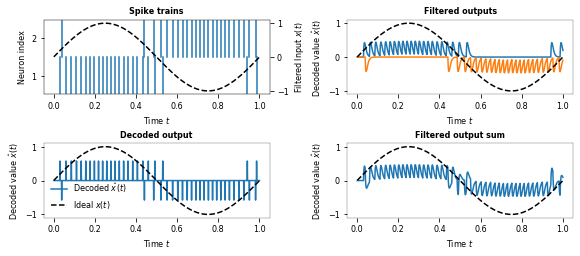

In [30]:
# Compute the spike trains for the two-neuron example and filter them with h
_, _, ts, xs, A, D = simulate_two_neurons()
ts_flt = ts - np.max(ts) / 2 # Centre the filter
fig = plot_filtered(ts, xs, A, synaptic_filter(ts_flt, tau=5e-3, n=1), D, scale=10)
fig.savefig("../two_neurons_synaptic_filter.pdf", transparent=True, bbox_inches='tight')

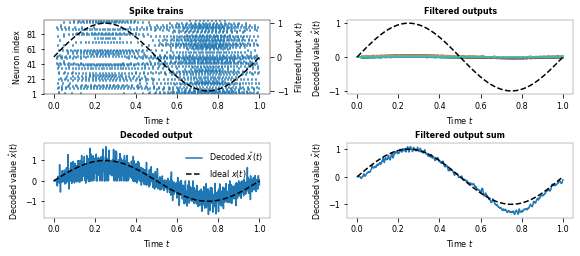

In [33]:
# Compute the spike trains for the two-neuron example and filter them with h
_, _, ts, xs, A, D = simulate_n_neurons(100)
ts_flt = ts - np.max(ts) / 2 # Centre the filter
fig = plot_filtered(ts, xs, A, synaptic_filter(ts_flt, tau=5e-3, n=1), D, scale=1.5)
fig.savefig("../n_neurons_synaptic_filter.pdf", transparent=True, bbox_inches='tight')